# Word Representation in Biomedical Domain

Before you start, please make sure you have read this notebook. You are encouraged to follow the recommendations but you are also free to develop your own solution from scratch.

## Marking Scheme

- Biomedical imaging project: 40%
  - 20%: accuracy of the final model on the test set
  - 20%: rationale of model design and final report
- Natural language processing project: 40%
  - 30%: completeness of the project
  - 10%: final report
- Presentation skills and team work: 20%

This project forms 40\% of the total score for summer/winter school. The marking scheme of each part of this project is provided below with a cap of 100\%.

You are allowed to use open source libraries as long as the libraries are properly cited in the code and final report. The usage of third-party code without proper reference will be treated as plagiarism, which will not be tolerated.

You are encouraged to develop the algorithms by yourselves (without using third-party code as much as possible). We will factor such effort into the marking process.


## Setup and Prerequisites

Recommended environment

- Python 3.7 or newer
- Free disk space: 100GB

Download the data

```sh
# navigate to the data folder
cd data

# download the data file
# which is also available at https://www.semanticscholar.org/cord19/download
wget https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2021-07-26/document_parses.tar.gz

# decompress the file which may take several minutes
tar -xf document_parses.tar.gz

# which creates a folder named document_parses
```


## Part 1 (20%): Parse the Data

The JSON files are located in two sub-folders in `document_parses`. You will need to scan all JSON files and extract text (i.e. `string`) from relevant fields (e.g. body text, abstract, titles).

You are encouraged to extract full article text from body text if possible. If the hardware resource is limited, you can extract from abstract or titles as alternatives.

Note: The number of JSON files is around 425k so it may take more than 10 minutes to parse all documents.

For more information about the dataset: https://www.semanticscholar.org/cord19/download

Recommended output:

- A list of text (`string`) extracted from JSON files.


In [30]:
# parse titles and abstracts

import os
import json
from tqdm import tqdm

data_root_path = "./data/document_parses/pdf_json/"
json_paths = [f for f in os.listdir(data_root_path)]

titles = []
abstracts = []

for json_path in tqdm(json_paths):
    with open(os.path.join(data_root_path, json_path)) as json_file:
        json_data = json.load(json_file)

        # parse the title
        titles.append(json_data["metadata"]["title"])

        # parse the abstract
        for entry in json_data["abstract"]:
            abstracts.append(entry["text"])

with open("./data/titles.txt", "w") as f:
    json.dump(titles, f)

with open("./data/abstracts.txt", "w") as f:
    json.dump(abstracts, f)

# about 5 minutes

100%|██████████| 240590/240590 [05:34<00:00, 720.23it/s]


## Part 2 (30%): Tokenization

Traverse the extracted text and segment the text into words (or tokens).

The following tracks can be developed in independently. You are encouraged to divide the workload to each team member.

Recommended output:

- Tokenizer(s) that is able to tokenize any input text.

Note: Because of the computation complexity of tokenizers, it may take hours/days to process all documents. Which tokenizer is more efficient? Any idea to speedup?


### Track 2.1 (10%): Use split()

Use the standard `split()` by Python.


In [30]:
import json
from tqdm import tqdm

with open("./data/titles.txt") as f:
    texts = json.load(f)


def containAlNum(text):
    for c in text:
        if c.isalnum():
            return True
    return False


tokens_list = []
for text in tqdm(texts):
    tokens = text.split()
    new_tokens = []
    for token in tokens:
        if containAlNum(token):
            new_tokens.append(token.strip(" ,./;:()?'\"").lower())
    if len(new_tokens) > 0:
        tokens_list.append(new_tokens)

with open("./data/tokens_list_split.txt", "w") as f:
    json.dump(tokens_list, f)

# about 3 seconds

100%|██████████| 240590/240590 [00:02<00:00, 111316.14it/s]


### Track 2.2 (10%): Use NLTK or SciSpaCy

NLTK tokenizer: https://www.nltk.org/api/nltk.tokenize.html

SciSpaCy: https://github.com/allenai/scispacy

Note: You may need to install NLTK and SpaCy so please refer to their websites for installation instructions.


In [1]:
from nltk.tokenize import word_tokenize
import json
from tqdm import tqdm

with open("./data/abstracts.txt") as f:
    texts = json.load(f)


def containAlNum(text):
    for c in text:
        if c.isalnum():
            return True
    return False


tokens_list = []
for text in tqdm(texts):
    tokens = word_tokenize(text)
    tokens = [
        token.lower().strip("-") for token in tokens if containAlNum(token)
    ]
    if len(tokens) > 0:
        tokens_list.append(tokens)

with open("./data/tokens_list_abstracts_NLTK.txt", "w") as f:
    json.dump(tokens_list, f)

100%|██████████| 240590/240590 [04:21<00:00, 921.38it/s] 


### Track 2.3 (10%): Use Byte-Pair Encoding (BPE)

Byte-Pair Encoding (BPE): https://huggingface.co/transformers/tokenizer_summary.html

Note: You may need to install Huggingface's transformers so please refer to its website for installation instructions.


In [2]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
import json
from tqdm import tqdm

with open("./data/titles.txt") as f:
    texts = json.load(f)


def containAlNum(text):
    for c in text:
        if c.isalnum():
            return True
    return False


tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer(
    special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

from tokenizers.pre_tokenizers import Whitespace

tokenizer.pre_tokenizer = Whitespace()

files = [
    f"data/wikitext-103-raw/wiki.{split}.raw"
    for split in ["test", "train", "valid"]
]
tokenizer.train(files, trainer)

tokens_list = []
for text in tqdm(texts):
    tokens = tokenizer.encode(text).tokens
    tokens = [
        token.lower().strip("-") for token in tokens if containAlNum(token)
    ]
    if len(tokens) > 0:
        tokens_list.append(tokens)

with open("./data/tokens_list_titles_BPE.txt", "w") as f:
    json.dump(tokens_list, f)

# about 90 seconds




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 240590/240590 [00:28<00:00, 8545.24it/s] 


### Track 2.4 (Bonus +5%): Build new Byte-Pair Encoding (BPE)

This track may be dependent on track 2.3.

The above pre-built tokenization methods may not be suitable for biomedical domain as the words/tokens (e.g. diseases, symptoms, chemicals, medications, phenotypes, genotypes etc.) can be very different from the words/tokens commonly used in daily life. Can you build and train a new BPE model for biomedical domain in particular?


In [ ]:
###################
# TODO: add your solution

###################

### Open Question (Optional):

- What are the pros and cons of the above tokenizers?


The built-in `split()` method is very simple and fast. However, it is not easy to handle special cases such as punctuations.

NLTK can extends functionalities easily, but it is still difficult to handle punctuations.

BPE can reduce the size of the vocabulary, but it needs to be trained on a large corpus and is not suitable for biomedical domain.


## Part 3 (30%): Build Word Representations

Build word representations for each extracted word. If the hardware resource is limited, you may limit the vocabulary size up to 10k words/tokens (or even smaller) and the dimension of representations up to 256.

The following tracks can be developed independently. You are encouraged to divide the workload to each team member.


### Track 3.1 (15%): Use N-gram Language Modeling

N-gram Language Modeling is to predict a target word by using `n` words from previous context. Specifically,

$P(w_i | w_{i-1}, w_{i-2}, ..., w_{i-n+1})$

For example, given a sentence, `"the main symptoms of COVID-19 are fever and cough"`, if $n=7$, we use previous context `["the", "main", "symptoms", "of", "COVID-19", "are"]` to predict the next word `"fever"`.

More to read: https://web.stanford.edu/~jurafsky/slp3/3.pdf

Recommended outputs:

- A fixed vector for each word/token.


In [ ]:
import json
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

with open("./data/tokens_list_abstracts_NLTK.txt") as f:
    tokens_list = json.load(f)

tokens_list = tokens_list[:100]

CONTEXT_SIZE = 3
EMBEDDING_DIM = 10
NUM_EPOCHS = 100

print("generate grams...")
grams = []
for tokens in tokens_list:
    for i in range(len(tokens) - CONTEXT_SIZE):
        history = tokens[i:i + CONTEXT_SIZE]
        target = tokens[i + CONTEXT_SIZE]
        grams.append((history, target))
print("grams count:", len(grams))

print("generate vocab...")
vocab = set()
for tokens in tokens_list:
    for token in tokens:
        vocab.add(token)
word2id = {word: i for i, word in enumerate(vocab)}
id2word = {i: word for word, i in word2id.items()}
print("vocab size:", len(vocab))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

histories_id = [[word2id[word] for word in history]
                for history, target in grams]
targets_id = [[word2id[target]] for history, target in grams]
histories_tensor = torch.tensor(histories_id, dtype=torch.long).to(device)
targets_tensor = torch.tensor(targets_id, dtype=torch.long).to(device)
grams_tensor = list(zip(histories_tensor, targets_tensor))


class N_gram(nn.Module):

    def __init__(self, vocab_size, context_size, embedding_dim):
        super(N_gram, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = self.linear1(embeds)
        out = F.relu(out)
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

    def extract(self, inputs):
        return self.embeddings(inputs)


n_gram = N_gram(len(vocab), CONTEXT_SIZE, EMBEDDING_DIM).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(n_gram.parameters(), lr=1e-2, weight_decay=1e-5)

print("training...")

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for history, target in tqdm(grams_tensor):
        n_gram.zero_grad()
        log_probs = n_gram(history)
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("epoch:", epoch, "average loss:", total_loss / len(grams_tensor))

print("training finished")

n_gram.eval()

vectors = n_gram.extract(torch.tensor(list(range(
    len(vocab)))).to(device)).data.cpu().numpy()
word2vector = {id2word[i]: vectors[i] for i in range(len(vocab))}

import pickle
with open("./data/word2vector_ngram.pkl", "wb") as f:
    pickle.dump(word2vector, f)

# about 40 minutes

### Track 3.2 (15%): Use Skip-gram with Negative Sampling

In skip-gram, we use a central word to predict its context. Specifically,

$P(w_{c-m}, ... w_{c-1}, w_{c+1}, ..., w_{c+m} | w_c)$

As the learning objective of skip-gram is computational inefficient (summation of entire vocabulary $|V|$), negative sampling is commonly applied to accelerate the training.

In negative sampling, we randomly select one word from the context as a positive sample, and randomly select $K$ words from the vocabulary as negative samples. As a result, the learning objective is updated to

$L = -\log\sigma(u^T_{t} v_c) - \sum_{k=1}^K\log\sigma(-u^T_k v_c)$, where $u_t$ is the vector embedding of positive sample from context, $u_k$ are the vector embeddings of negative samples, $v_c$ is the vector embedding of the central word, $\sigma$ refers to the sigmoid function.

More to read http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf section 4.3 and 4.4

Recommended outputs:

- A fixed vector for each word/token.


In [ ]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import random
import numpy as np
import collections

MAX_VOCAB_SIZE = 1000
MIN_COUNT = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("load data...")
with open("./data/tokens_list_abstracts_NLTK.txt") as f:
    tokens_list = json.load(f)

tokens_list = tokens_list[:10000]
print("load data finished")

print("construct vocab...")
count = collections.Counter([
    token for tokens in tokens_list for token in tokens
]).most_common(MAX_VOCAB_SIZE - 1)
count = [c for c in count if c[1] >= MIN_COUNT]
count = [("UNK", -1)] + count
vocab_size = len(count)
word2id = {word: i for i, (word, _) in enumerate(count)}
id2word = {i: word for word, i in word2id.items()}

# data is a list of lists of ids
data = []
unk_count = 0
for tokens in tokens_list:
    data.append([])
    for token in tokens:
        if token in word2id:
            data[-1].append(word2id[token])
        else:
            data[-1].append(word2id['UNK'])
            unk_count += 1
count[0] = ("UNK", unk_count)
count.sort(key=lambda x: x[1], reverse=True)
print("construct vocab finished")

print("generate train data...")
WINDOW_SIZE = 2
train_data = []
for tokens in tqdm(data):
    for i in range(len(tokens)):
        # the first word in the vocab is UNK, and it is not used in training
        if tokens[i] == word2id['UNK']:
            continue
        for j in range(max(0, i - WINDOW_SIZE),
                       min(len(tokens), i + WINDOW_SIZE + 1)):
            if i != j and tokens[j] != word2id['UNK']:
                train_data.append(
                    (torch.tensor(tokens[i],
                                  dtype=torch.long).view(1, -1).to(device),
                     torch.tensor(tokens[j],
                                  dtype=torch.long).view(1, -1).to(device)))

print("generate train data finished")


def get_batch(batch_size, train_data):
    start_index, end_index = 0, batch_size
    while end_index < len(train_data):
        batch = train_data[start_index:end_index]
        start_index, end_index = end_index, end_index + batch_size
        yield batch
    if start_index < len(train_data):
        batch = train_data[start_index:]
        yield batch


# unigram_table is used for negative sampling
num_total_words = sum(c for w, c in count[1:vocab_size])
unigram_table = []
for i in range(1, vocab_size):
    unigram_table.extend([i] * int(
        ((count[i][1] / num_total_words)**0.75) / 0.001))


def negative_sampling(targets, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        neg_sample = []
        while len(neg_sample) < k:
            neg = random.choice(unigram_table)
            neg_sample.append(neg)
        neg_samples.append(neg_sample)
    return torch.tensor(neg_samples, dtype=torch.long).to(device)


class SkipGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embeddings_u = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings_v = nn.Embedding(vocab_size, embedding_dim)
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embeddings_v(center_words)
        target_embeds = self.embeddings_u(target_words)
        negative_embeds = -self.embeddings_u(negative_words)

        positive_score = target_embeds.bmm(center_embeds.transpose(
            1, 2)).squeeze(2)
        negative_score = torch.sum(
            negative_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2), 1)
        loss = self.logsigmoid(positive_score) + self.logsigmoid(
            negative_score)
        return -torch.mean(loss)

    def extract(self, inputs):
        embeds = self.embeddings_v(inputs)
        return embeds


EMBEDDING_DIM = 100
BATCH_SIZE = 128

model = SkipGram(vocab_size, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("training...")
for epoch in range(10):
    losses = []
    for i, batch in tqdm(enumerate(get_batch(BATCH_SIZE, train_data))):
        inputs, targets = zip(*batch)
        inputs = torch.cat(inputs)
        targets = torch.cat(targets)
        negs = negative_sampling(targets, 5)
        model.zero_grad()
        loss = model(inputs, targets, negs)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            losses.append(loss.item())
    
    print("epoch: {}, loss: {}".format(epoch, np.mean(losses)))
        

print("training finished")

vectors = model.extract(torch.tensor(list(
    range(vocab_size))).to(device)).data.cpu().numpy()
word2vector = {id2word[i]: vectors[i] for i in range(1, vocab_size)}

import pickle
with open('./data/word2vector_skipgram.pkl', 'wb') as f:
    pickle.dump(word2vector, f)

# about 10 minutes

In [1]:
import pickle
import numpy as np

with open('./data/word2vector_skipgram.pkl', 'rb') as f:
    word2vector = pickle.load(f)


def find_similarity(word):
    target_v = word2vector[word]
    similarities = []
    for w, v in word2vector.items():
        if w == word:
            continue
        similarity = np.dot(target_v,
                            v) / (np.linalg.norm(target_v) * np.linalg.norm(v))
        similarities.append((w, similarity))
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:10]


print(find_similarity('covid-19'))

[('covid', 0.51944244), ('coronavirus', 0.41292483), ('influenza', 0.3977386), ('sars-cov-2', 0.37508467), ('disease', 0.35065684), ('2019', 0.33651137), ('quarantine', 0.3363073), ('progression', 0.33564624), ('development', 0.32524797), ('pneumonia', 0.3229092)]


### Track 3.3 (Bonus +5%): Use Contextualised Word Representation by Masked Language Model (MLM)

BERT introduces a new language model for pre-training named Masked Language Model (MLM). The advantage of MLM is that the word representations by MLM will be contextualised.

For example, "stick" may have different meanings in different context. By N-gram language modeling and word2vec (skip-gram, CBOW), the word representation of "stick" is fixed regardless of its context. However, MLM will learn the representation of "stick" dynamically based on context. In other words, "stick" will have different representations in different context by MLM.

More to read: http://jalammar.github.io/illustrated-bert/ and https://arxiv.org/pdf/1810.04805.pdf

Recommended outputs:

- An algorithm that is able to generate contextualised representation in real time.


In [ ]:
###################
# TODO: add your solution

###################

## Part 4 (20%): Explore the Word Representations

The following tracks can be finished independently. You are encouraged to divide workload to each team member.


In [1]:
# remove stopwords
import pickle

with open('./data/stopwords.txt') as file:
    stopwords = [line.strip('\'\n') for line in file.readlines()]
    stopwords = set(stopwords)

with open("./data/word2vector_skipgram.pkl", "rb") as f:
    word2vec = pickle.load(f)

for word in list(word2vec.keys()):
    if word in stopwords or word.isdigit():
        del word2vec[word]

### Track 4.1 (5%): Visualise the word representations by t-SNE

t-SNE is an algorithm to reduce dimensionality and commonly used to visualise high-dimension vectors. Use t-SNE to visualise the word representations. You may visualise up to 1000 words as t-SNE is highly computationally complex.

More about t-SNE: https://lvdmaaten.github.io/tsne/

Recommended output:

- A diagram by t-SNE based on representations of up to 1000 words.


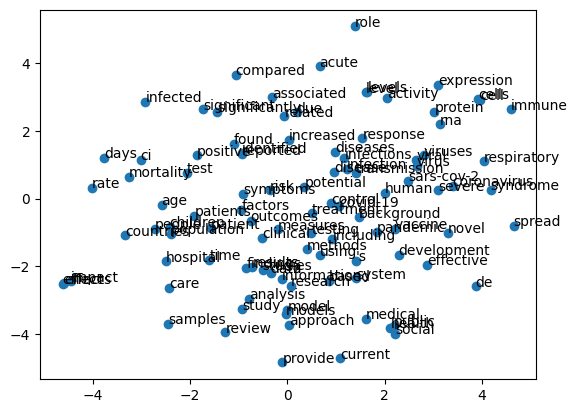

In [2]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 提取前 1000 个词的词向量
words = list(word2vec.keys())[:100]
vectors = np.array([word2vec[word] for word in words])

# 使用 TSNE 降维
tsne = TSNE(n_components=2, random_state=0)
X_reduced = tsne.fit_transform(vectors)

# 可视化
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (X_reduced[i, 0], X_reduced[i, 1]))
plt.show()

### Track 4.2 (5%): Visualise the Word Representations of Biomedical Entities by t-SNE

Instead of visualising the word representations of the entire vocabulary (or 1000 words that are selected at random), visualise the word representations of words which are biomedical entities. For example, fever, cough, diabetes etc. Based on the category of those biomedical entities, can you assign different colours to the entities and see if the entities from the same category can be clustered by t-SNE? For example, sinusitis and cough are both respiratory diseases so they should be assigned with the same colour and ideally their representations should be close to each other by t-SNE. Another example, Alzheimer and headache are neurological diseases which should be assigned by another colour.

Examples of biomedical ontology: https://www.ebi.ac.uk/ols/ontologies/hp and https://en.wikipedia.org/wiki/International_Classification_of_Diseases

Recommended output:

- A diagram with colours by t-SNE based on representations of biomedical entities.


In [ ]:
###################
# TODO: add your solution

###################

### Track 4.3 (5%): Co-occurrence

- What are the biomedical entities which frequently co-occur with COVID-19 (or coronavirus)?

Recommended outputs:

- A sorted list of biomedical entities and description on how the entities are selected and sorted.


In [ ]:
###################
# TODO: add your solution

###################

### Track 4.4 (5%): Semantic Similarity

- What are the biomedical entities which have closest semantic similarity COVID-19 (or coronavirus) based on word representations?

Recommended outputs:

- A sorted list of biomedical entities and description on how the entities are selected and sorted.


In [ ]:
###################
# TODO: add your solution

###################

### Open Question (Optional): What else can you discover?


In [ ]:
###################
# TODO: add your solution

###################

## Part 5 (Bonus +10%): Open Challenge: Mining Biomedical Knowledge

A fundamental task in clinical/biomedical natural language processing is to extract intelligence from biomedical text corpus automatically and efficiently. More specifically, the intelligence may include biomedical entities mentioned in text, relations between biomedical entities, clinical features of patients, progression of diseases, all of which can be used to predict, understand and improve patients' outcomes.

This open challenge is to build a biomedical knowledge graph based on the CORD-19 dataset and mine useful information from it. We recommend the following steps but you are also encouraged to develop your solution from scratch.


### Extract Biomedical Entities from Text

Extract biomedical entities (such as fever, cough, headache, lung cancer, heart attack) from text. Note that:

- The biomedical entities may consist of multiple words. For example, heart attack, multiple myeloma etc.
- The biomedical entities may be written in synonyms. For example, low blood pressure for hypotension.
- The biomedical entities may be written in different forms. For example, smoking, smokes, smoked.


In [ ]:
###################
# TODO: add your solution

###################

### Extract Relations between Biomedical Entities

Extract relations between biomedical entities based on their appearance in text. You may define a relation between biomedical entities by one or more of the following criteria:

- The biomedical entities frequently co-occur together.
- The biomedical entities have similar word representations.
- The biomedical entities have clear relations based on textual narratives. For example, "The most common symptoms for COVID-19 are fever and cough" so we know there are relations between "COVID-19", "fever" and "cough".


In [ ]:
###################
# TODO: add your solution

###################

### Build a Biomedical Knowledge Graph of COVID-19

Build a knowledge graph based on the results from track 5.1 and 5.2 and visualise it.


In [ ]:
###################
# TODO: add your solution

###################